In [1]:
import duckdb
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [2]:
receiver_stat_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
]

team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
]
opp_stat_cols = [
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

game_context_cols = [
	"yardline_100",
	"down",
	"goal_to_go",
	"ydstogo",
	"posteam_score",
	"defteam_score",
	"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line'
]

air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    'yards_per_target_roll',
    'yards_per_catch_roll',
] + game_context_cols + ['passing_yards_opp_roll']

In [3]:
passes = Quack.query(f"""
select pbp.game_id, pbp.air_yards,
	{', '.join(('pbp.' + x for x in game_context_cols))},
	{', '.join(('t.' + x for x in team_stat_cols))},
	{', '.join(('o.' + x for x in opp_stat_cols))},
	{', '.join(('r.' + x for x in receiver_stat_cols))},
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.receiver_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.pass = 1
	and pbp.pass_attempt = 1
	and pbp.down is not null
    and pbp.play_type = 'pass'
""")

In [4]:
import torch
import torch.nn as nn

class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
		super(masked_model, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		nn.Linear(n_hidden, n_hidden),nn.ReLU(),
		nn.Dropout(p=dropout_prob),
		nn.Linear(n_hidden, n_hidden),nn.ReLU(),
		)
		self.add_yardline = nn.Linear(n_hidden + 1, n_out)
	def forward(self, x):
		# Extract the feature to pass to the final layer (e.g., the first feature)
		feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]

		x = self.main_layers(x)
		x = torch.cat((x, feature_to_pass), dim=1) 
		x = self.add_yardline(x)



		#end_zone = feature_to_pass[:,0].clone().detach().view(-1)
		#accum_mask = torch.nn.functional.one_hot(end_zone.type(torch.LongTensor)+30, self.n_out)
		#accum_mask =  accum_mask +  torch.sum(accum_mask, dim=1, keepdims=True) - torch.cumsum(accum_mask, dim=1)
		#accum_mask = accum_mask.type(torch.bool)
		#x = x.masked_fill(~accum_mask, float('-1000'))

		return x

In [5]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer

	X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
	model = model = masked_model(
	n_in=n_in,
	n_out=n_out,
	n_hidden=n_hidden,
	dropout_prob=0.
	).to(device)
	criterion = nn.CrossEntropyLoss()  # Suitable for classification
	optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)

	# Training loop
	epochs = epochs
	batch_size = 64

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			indices = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[indices], train_y[indices]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]


			loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
			loss.backward()
			optimizer.step()

			epoch_loss += loss.item()

		print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(Xtr):.4f}")

		# Evaluation on the test set
	model.eval()
	with torch.no_grad():
		test_preds = model(Xtst)  # Shape: [num_samples, 100]
		test_loss = criterion(test_preds, test_y).item() 
		accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
	print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

	test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
	samples = torch.clamp( torch.multinomial(test_preds,100,replacement=True),max=76) - 30
	avg = round(samples.double().mean().item(), 3)
	plt.hist(test_preds, alpha=0.5, color='r')
	plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
	return model

In [6]:
passes['air_yards_20'] = (passes['air_yards'] + 20).clip(lower=0, upper=130)
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = data[air_yards_cols]
y = data['air_yards_20']
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

(203216,)

Epoch 1/5, Loss: 0.0603
Epoch 2/5, Loss: 0.0561
Epoch 3/5, Loss: 0.0559
Epoch 4/5, Loss: 0.0559
Epoch 5/5, Loss: 0.0558
Test Loss: 3.5774, Test Accuracy: 0.0715


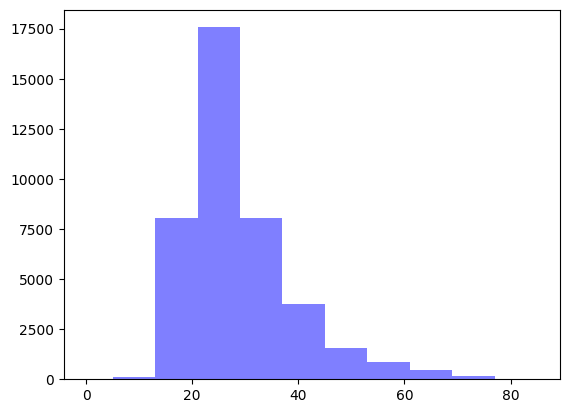

In [16]:
air_yards_model = train_model(X, y, num_feats, 119, n_hidden=512, epochs = 5) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')

Actual mean: 8.53, Model mean: nan


(-10.0, 30.0)

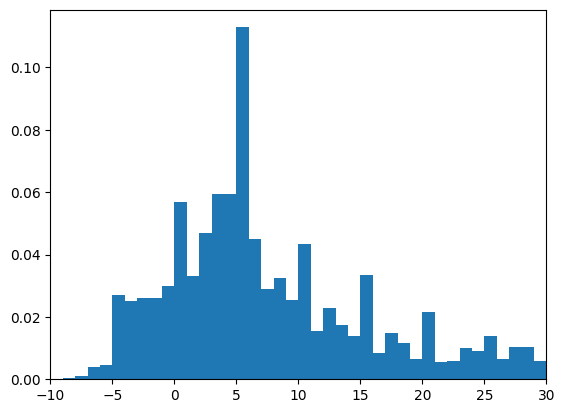

In [17]:
def sample_model_yardline(yard):
	inp = passes.loc[passes.yardline_100 == yard, air_yards_cols]
	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = air_yards_model(inp).mean(0).detach().numpy()
	exp_logits = np.exp(out - np.max(out))  # subtract max for numerical stability
	probs = exp_logits / exp_logits.sum()
	y = passes.loc[passes.yardline_100 == yard, ['air_yards']]
	plt.hist(y, range(-10,yard+2), density=True)


		# compute means
	actual_mean = y['air_yards'].mean()
	model_mean = (np.arange(len(probs)) - 30) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	
	return probs

yard = 30
plt.plot(range(-20 ,99 ),sample_model_yardline(yard))
plt.xlim(-10,30)